By Group 4: Qianjing Liang, Elouise Matthews, Naman Ratra, and Luis Sejas

## Overview

#### This notebook will present and compare the analysis of three different data sets using the following classifier methods:
- LinearSVC
- KNeighbors
- Decision Tree
- Random Forest
- Quadratic Discriminant Analysis
- Logistic Regression
- SGD Classifier

#### Note: 
1. For all datasets, the accuracy score will be selected as the metrics (detailed explanation in their correspnoding section)
    
2. The original versions of the datasets used here can be found [here](https://drive.google.com/drive/folders/1NjKW-zpihWhJxA4U45ZoNbtDevQEeEzJ?usp=sharing).

## Part I. Preparation

In [1]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from sklearn.random_projection import SparseRandomProjection

from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import random
random.seed(10) # Set global random seed

import warnings
warnings.filterwarnings('ignore')

import time

### Prepare a function for the analysis and comparisons of different data sets.

In [2]:
def model_comparison(X, y, data_name):
    '''
    Trains 6 different classifiers on the given data and its subsets 
    and returns 6 subplots, each showing the baseline accuracy score 
    as well as the changes in the accuracies when sparse random 
    projection is applied and different numbers of the original
    dataset's dimensions are kept.

    Parameters:
        X (DataFrame): predictor variables of the data set
        y (Series): target variable of the dataset
        data_name (str): description of the data
    '''
    models = [KNeighborsClassifier(), DecisionTreeClassifier(), 
              QuadraticDiscriminantAnalysis(), 
              LogisticRegression(solver='liblinear'), 
              SGDClassifier(), LinearSVC()] # Types of models to 
                                            # be trained and compared
    
    fig, ax = plt.subplots(3,2,figsize=(14,15),
                           constrained_layout=True) # Prepare the subplots

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.33)
    
    for i in range(6):
        model = models[i] # Select one of the 6 models to fit the data
        model.fit(X_train, y_train)
        baseline = metrics.accuracy_score(model.predict(X_test), y_test)
        
        # Set up empty list for recording accuracy scores and 
        # dimension range for plotting (the range is divided
        # into 50 equal steps)
        accuracies = []
        dims = np.int32(np.linspace(2, X.shape[1], 50))

        for dim in dims:
            # Create random projection
            sp = SparseRandomProjection(n_components = dim)
            X_sp = sp.fit_transform(X_train)
 
            # Train classifier on the sparse random projection
            model = models[i]
            model.fit(X_sp, y_train)
 
            # Evaluate model and update accuracies
            test = sp.transform(X_test)
            accuracies.append(metrics.accuracy_score(model.predict(test), 
                                                     y_test))
        
        # Plot baseline and random projection accuracies
        ax[i//2,i%2].plot(dims, [baseline] * len(accuracies), color = "r", 
                          label='baseline accuracy')
        ax[i//2,i%2].plot(dims, accuracies, 
                          label='accuracy with random projection')
        
        ax[i//2,i%2].set_xlabel("Number of dimensions kept")
        ax[i//2,i%2].set_ylabel("Accuracy")
        ax[i//2,i%2].set_xlim([2, X.shape[1]])
        ax[i//2,i%2].set_ylim([0, 1])
        ax[i//2,i%2].legend()
        ax[i//2,i%2].set_title('Plot ('+str(i+1)+'): Accuracy of '+ \
                                data_name +' data using '+\
                                str(models[i]).split("(")[0])
    plt.show()

## Part II. Hand Posture Data
The original data is from https://archive.ics.uci.edu/ml/datasets/MoCap+Hand+Postures. The variables of the data set are mainly data collected from sensors of a glove, which correspond to different classes of hand postures. Originally, there are 38 columns, consisting of a column for ID number, a column for the target class (the specific type of the hand posture), and 36 columns of sensor information.

The .csv file imported here has been preprocessed as the original dataset has many missing values in certain columns, which have been removed. After removing the columns with many missing values, rows with missing values have also been removed to perserve as many columns as possible.

In [3]:
hand = pd.read_csv('HandPosture.csv')

# The dataset is of a classification type and has 33 predictors
print('The data set has ', hand.shape[0], ' rows and ',
      hand.shape[1], ' columns.')

The data set has  14753  rows and  34  columns.


The distribution of the target class is not balanced in the data. Moreover, due to the preprocessing that removed rows with missing values, only data for four classes have been kept.

In [4]:
hand.Class.value_counts()

2    10524
5     4180
1       48
0        1
Name: Class, dtype: int64

To have a more balanced data, the data points of class 1 and class 0 are dropped here (due to their small numbers of observations), leaving only class 2 and class 5. Therefore, the data set will become a binary classification problem.

In [5]:
hand_sampled = hand[hand['Class']!=0][hand['Class']!=1]

# Rename the remaining class 2 and class 5 to be 0 and 1 (since it's
# binary classification now)
hand_sampled['Class'] = hand_sampled['Class'].replace(2,0).replace(5,1)
hand_sampled.Class.value_counts()

0    10524
1     4180
Name: Class, dtype: int64

For this dataset, there are 2 different hand signs. Unlike the case for medical conditions or financial investments, there is no larger risk or benefit associated with either of the 2 classes. Accuracy and $f_{1}$ score are valid metrics when equal weighting is assigned to both/all classes. $f_{1}$ score is a better metric when the dataset is unbalanced, but here the ratio of 5:2 is not extremely unbalanced, and we also have sufficiently large data to downsample it to become a balanced dataset. Moreover, if possible, accuracy is more convenient than the $f_{1}$ score as its representation is more intuitive. Therefore, accuracy score is used here.

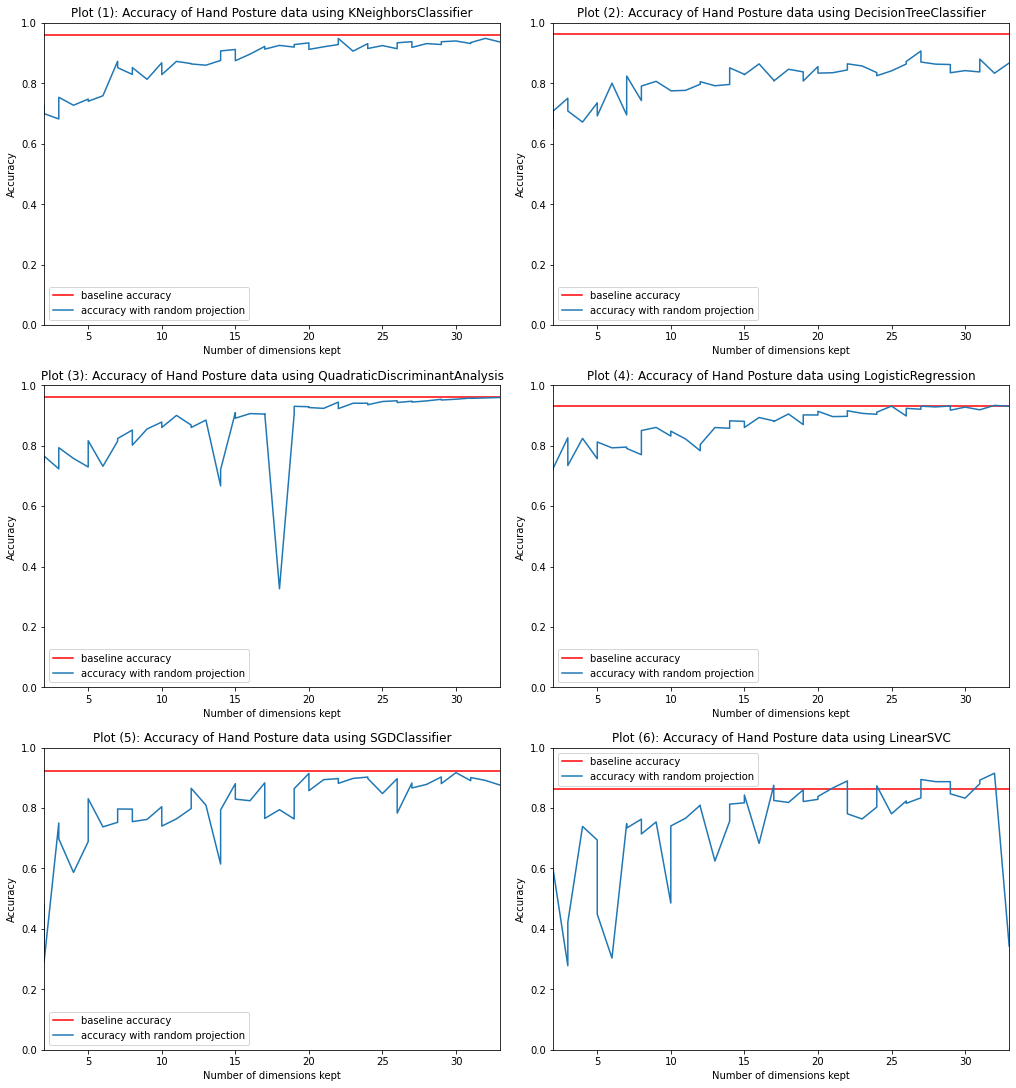

Time spent:  109.06442523002625


In [6]:
X = hand_sampled.drop('Class', axis=1)
y = hand_sampled['Class']

start = time.time()
model_comparison(X, y, 'Hand Posture')
end = time.time()
print("Time spent: ", end-start)

### Analysis of Part II:
Compared to the other models the KNN classifier (as shown in Plot 1) and Logistic Regression classifier (as shown in Plot 4) yield better results (in terms of the smoothness of the curve around the baseline accuracy score). In the case of KNN, the accuracy score starts to approximately reach the baseline when Number of dimensions kept = 22. Meanwhile, for Logistic Regression, 25 dimensions are enough to reach the baseline accuracy after using sparse random projection. 

In comparison, other models (as shown in Plot 2, Plot 3, Plot5, and Plot 6) show accuracy scores that are not approaching the baseline or having huge fluctuations around the baseline.

## Part III. Crop Mapping Data
### Introduction
The original data set is from https://archive.ics.uci.edu/ml/datasets/Crop+mapping+using+fused+optical-radar+data+set. It contains 175 columns, one of which is for the class of crops and the others are data from different sensors.

The first column is the target variable of the dataset, which has 7 classes in total. As the original dataset was imbalanced and relatively large, it has been downsampled to achieve balanced numbers for each class. (The details of the downsampling can be found in the notebook/pdf named "Preprocessing for CropMapping".)
There are 174 predictor variables. 

In [7]:
crop = pd.read_csv('CropMapping.csv')
crop.label.value_counts() #distribution of the target variable

4    1143
1    1143
5    1143
2    1143
6    1143
3    1143
7    1143
Name: label, dtype: int64

### Metric selection
As the dataset has a balanced distribution in its target variable, it makes sense to choose the accuracy score as its metric.

The data set has  8001  rows and  175  columns.


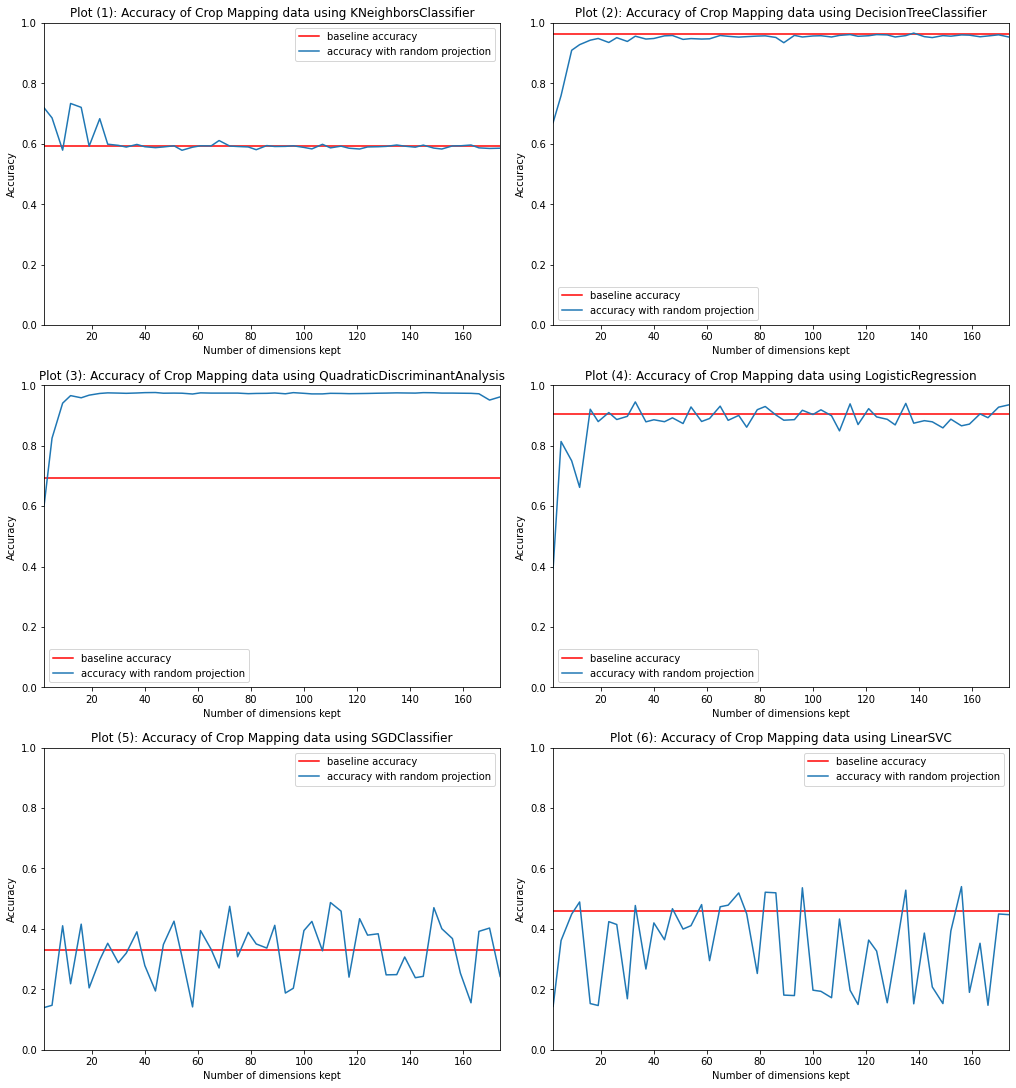

Time spent:  585.703449010849


In [8]:
print('The data set has ', crop.shape[0], ' rows and ',
      crop.shape[1], ' columns.')

X = crop.drop('label', axis=1)
y = crop['label']

start = time.time()
model_comparison(X, y, 'Crop Mapping')
end = time.time()
print("Time spent: ", end-start)

### Analysis of Part III:
Compared to the other models, Decision Tree (as shown in Plot 2) and Quadratic Discriminant Analysis (as shown in Plot 3) show better results (in terms of the smoothness of the curve around the baseline accuracy score). In the case of Decision Tree, the accuracy score starts to reach the baseline when Number of dimensions kept = 35 (approximately). Meanwhile, for Quadratic Discriminant Analysis, less than 10 dimensions are enough to reach the baseline accuracy after using sparse random projection.

In comparison, other models (as shown in Plot 1, Plot 4, Plot5, and Plot 6) show accuracy scores that are showing huge fluctuations around the baseline.

## Part IV. Beans Data
### Introduction
The original data is from https://archive.ics.uci.edu/ml/datasets/Dry+Bean+Dataset. The data set has 17 columns in total, one of which is the target variable (the type of dry beans), which has 7 classes, while the others are predictor variables. These predictor columns are the attributes of the beans, such as their solidity and compactness.

### Metric selection
The target variable 'Class' is distributed quite continuously, so accuracy will continue to be suitable for the models' evaluation for this dataset.

The data set has  13611  rows and  17  columns.


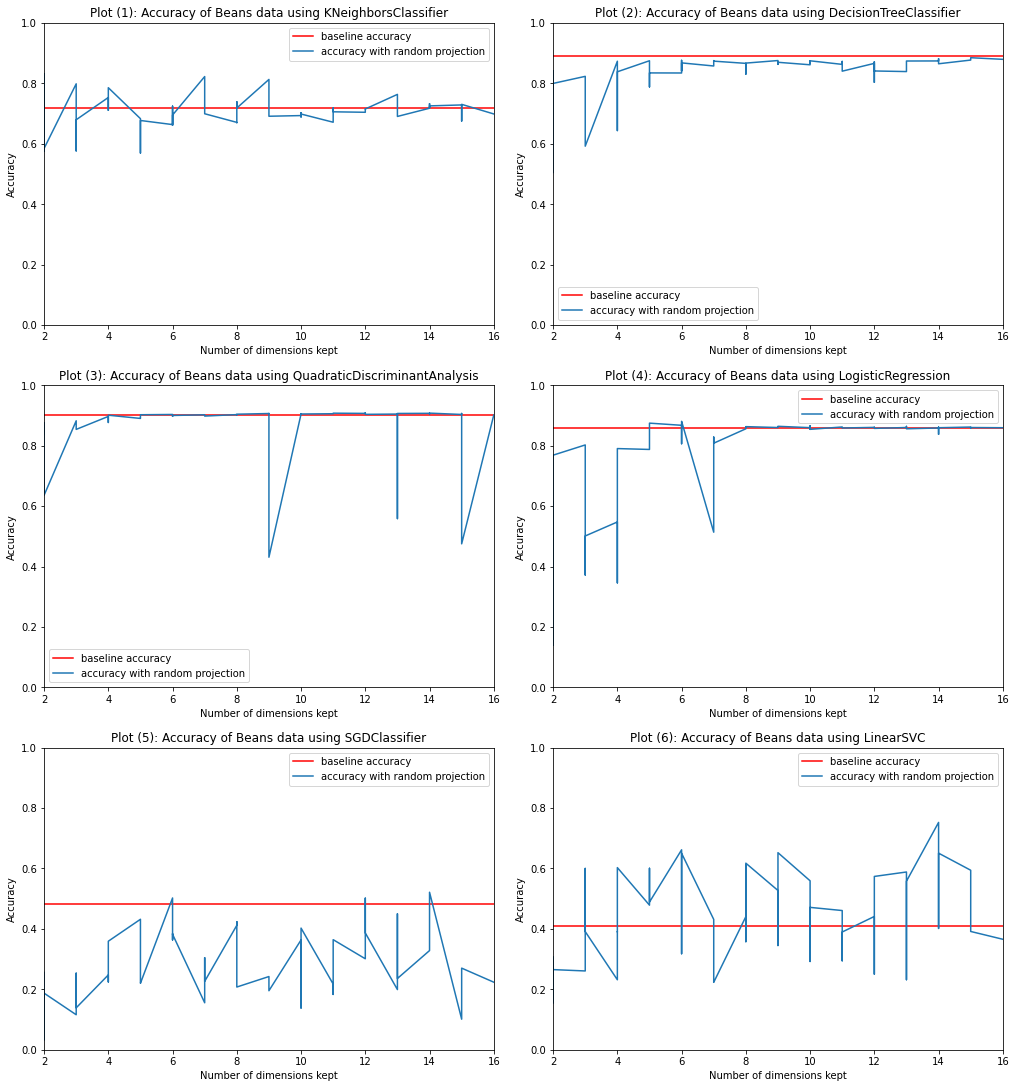

Time spent:  181.43032026290894


In [9]:
beans = pd.read_csv('BeansData.csv')

print('The data set has ', beans.shape[0], ' rows and ',
      beans.shape[1], ' columns.')

X = beans.drop('Class', axis=1)
y = beans['Class']

start = time.time()
model_comparison(X, y, 'Beans')
end = time.time()
print("Time spent: ", end-start)

### Analysis of Part IV:
Compared to the other models, Decision Tree (as shown in Plot 2) shows better results (in terms of the smoothness of the curve around the baseline accuracy score), and the accuracy score starts to approach the baseline when Number of dimensions kept = 7 (approximately). 

In comparison, other models (as shown in Plot 1, Plot 3, Plot 4, Plot5, and Plot 6) show accuracy scores that are showing huge fluctuations around the baseline.

## Part V. Final Analysis and Conclusion 

1. By applying the random projections using different dimensions, the results showed that the more predictor variables, the smoother the curve. As the number of dimensions increase from 16 (for the Beans dataset) to 34 (for the Hands Posture dataset) to 174 (for the Crop Mapping dataset), the shapes of their best accuracy curves become better.

    It has to be considered that the dimensions are divided into 50 steps for all datasets. Given that the dimension size must be a natural number, the 50 different dimension sizes are only unique if the dataset has more than 50 variables. In the Beans and occasionally Hand Posture dataset, there are many completely vertical lines. This is due to some runs using identical dimension sizes due to rounding decimals. However, having smaller dimension sizes does not seem to be a direct cause of the fluctuations. On the Crop Mapping dataset's Decision Tree Classifier, for example, we can see that there is insignificant fluctuation from dimension 15 onwards. A possible reason is that with lower dimension sizes, each random projection has fewer features to choose from.
    

2. It seems that the lower the baseline accuracy, the more unstable the projection accuracies are. For example, in the Hand Posture data set, the last model (as shown in Plot 6 of Part II) has relatively low accuracy baseline scores compared to the others, and the changes in the accuracy curves show larger fluctuations. Similar observations can be made regarding the Plot 5 and Plot 6 of Part III for the Crop Mapping dataset. One possible reason is that when the models have low baseline accuracy scores, it is very likely that the models are not suitable for the dataset and performing very poorly. Therefore, when applying sparse random projection and fitting the models back to the reduced dimensions, the corresponding accuracy scores are likely to be very unstable.


3. Compared to the Beans dataset (in Part IV), the other two generally show better results (in terms of the smoothness of the curve around and above the accuracy baseline score). One possible explanation is that the variables of the Beans dataset are not all in Euclidean distance space. In comparison, as the variables of the Hand Posture and the Crop Mapping datasets are generated by sensors, which are in Euclidean distances, methods such as Sparse Random Projection, which is meant to perserve the distances of data points from the original data space, will be more applicable to these two datasets.

### Final remarks:
- For the same data set, a change in classifiers can lead to very different results. This can be shown by the differences in the shapes of the accuracy curve as well as the realtionships between the accuracy curve and the baseline accuracy score.

- It is possible that with some additional parameter tuning, better results could be achieved, but from these observations, we can at least conclude that random projections can be very helpful for datasets with a large (50+) number of features, and also depends on the compatibility of the model with the dataset. 